## Great Britain Road Safety Dataset

These files provide detailed road safety data about the circumstances of personal injury road accidents in Great Britain from 1979, the types of vehicles involved and the consequential casualties. The statistics relate only to personal injury accidents on public roads that are reported to the police, and subsequently recorded, using the STATS19 accident reporting form.

The dictionary of the colums are defined here:
https://www.dropbox.com/s/239wnyobolbt0im/Road-Accident-Safety-Data-Guide.xls?dl=0

This analysis is for the Data of 2019

- We are first going to take a look at the data and understand the data
- We will do some feature extraction
- We will look for class imbalances
- Experiment an Ensemble of Models
- Build a classifier in Scikit Learn

Target Variable is "Did Police Attend"

        - 1 - Yes
        - 2 - No


In [4]:
import pandas as pd
import seaborn as sns
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline


import itertools
import pickle
from mlxtend.plotting import plot_decision_regions
from mlxtend.classifier import StackingClassifier # <-- note: this is not from sklearn!
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score,classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import (RandomForestClassifier, ExtraTreesClassifier, VotingClassifier, 
                              AdaBoostClassifier, BaggingRegressor)

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score, roc_auc_score
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score

from h2o.estimators.random_forest import H2ORandomForestEstimator


#road_safety = pd.read_csv("DfTRoadSafety_Accidents_2014.csv")
#road_safety.to_pickle("road_safety.pkl")

In [5]:
pd.set_option('display.max_rows', 500)

In [6]:
road_safety = pd.read_pickle("../road_safety.pkl")

In [6]:
road_safety.columns

Index(['Accident_Index', 'Location_Easting_OSGR', 'Location_Northing_OSGR',
       'Longitude', 'Latitude', 'Police_Force', 'Accident_Severity',
       'Number_of_Vehicles', 'Number_of_Casualties', 'Date', 'Day_of_Week',
       'Time', 'Local_Authority_(District)', 'Local_Authority_(Highway)',
       '1st_Road_Class', '1st_Road_Number', 'Road_Type', 'Speed_limit',
       'Junction_Detail', 'Junction_Control', '2nd_Road_Class',
       '2nd_Road_Number', 'Pedestrian_Crossing-Human_Control',
       'Pedestrian_Crossing-Physical_Facilities', 'Light_Conditions',
       'Weather_Conditions', 'Road_Surface_Conditions',
       'Special_Conditions_at_Site', 'Carriageway_Hazards',
       'Urban_or_Rural_Area', 'Did_Police_Officer_Attend_Scene_of_Accident',
       'LSOA_of_Accident_Location'],
      dtype='object')

In [10]:
road_safety["Carriageway_Hazards"].value_counts()

 0    143909
 2       939
 7       692
 6       450
 3       182
 1       149
-1         1
Name: Carriageway_Hazards, dtype: int64

In [8]:
road_safety.describe()

,Location_Easting_OSGR,Location_Northing_OSGR,Longitude,Latitude,Police_Force,Accident_Severity,Number_of_Vehicles,Number_of_Casualties,Day_of_Week,Local_Authority_(District),...,2nd_Road_Number,Pedestrian_Crossing-Human_Control,Pedestrian_Crossing-Physical_Facilities,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Special_Conditions_at_Site,Carriageway_Hazards,Urban_or_Rural_Area,Did_Police_Officer_Attend_Scene_of_Accident
count,146322.000000,1.463220e+05,146322.000000,146322.000000,146322.000000,146322.000000,146322.000000,146322.000000,146322.00000,146322.000000,...,146322.000000,146322.000000,146322.000000,146322.000000,146322.000000,146322.000000,146322.000000,146322.000000,146322.000000,146322.000000
mean,447029.362475,2.903741e+05,-1.328712,52.500882,29.895839,2.836033,1.835179,1.329103,4.09868,343.380537,...,377.446023,0.008386,0.857725,1.924099,1.500595,1.328132,0.096985,0.069135,1.341951,1.182577
std,95158.326674,1.578227e+05,1.397358,1.421337,25.190838,0.399682,0.700208,0.857469,1.91668,258.280727,...,1288.061037,0.119877,1.947539,1.627001,1.514131,0.568551,0.685515,0.612831,0.474365,0.386320
min,70951.000000,1.030400e+04,-7.450342,49.913077,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,...,-1.000000,0.000000,0.000000,1.000000,1.000000,-1.000000,-1.000000,-1.000000,1.000000,1.000000
25%,384364.250000,1.765900e+05,-2.235527,51.474928,6.000000,3.000000,1.000000,1.000000,2.00000,104.000000,...,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000
50%,451306.000000,2.416200e+05,-1.238819,52.055123,30.000000,3.000000,2.000000,1.000000,4.00000,323.000000,...,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000
75%,526830.000000,3.911760e+05,-0.170586,53.414623,45.000000,3.000000,2.000000,1.000000,6.00000,517.000000,...,0.000000,0.000000,0.000000,4.000000,1.000000,2.000000,0.000000,0.000000,2.000000,1.000000
max,655309.000000,1.190858e+06,1.758797,60.597984,98.000000,3.000000,21.000000,93.000000,7.00000,941.000000,...,9999.000000,2.000000,8.000000,7.000000,9.000000,5.000000,7.000000,7.000000,2.000000,2.000000


In [7]:
road_safety.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146322 entries, 0 to 146321
Data columns (total 32 columns):
Accident_Index                                 146322 non-null object
Location_Easting_OSGR                          146322 non-null int64
Location_Northing_OSGR                         146322 non-null int64
Longitude                                      146322 non-null float64
Latitude                                       146322 non-null float64
Police_Force                                   146322 non-null int64
Accident_Severity                              146322 non-null int64
Number_of_Vehicles                             146322 non-null int64
Number_of_Casualties                           146322 non-null int64
Date                                           146322 non-null object
Day_of_Week                                    146322 non-null int64
Time                                           146322 non-null object
Local_Authority_(District)                     146322 

### Initial Analysis
- The dataset is fairly clean
- It has about 146322 records
- LSOA_of_Accident_Location - Is the only column with missing values
- Lots of categorical values that needs to be changed to dummy variables


### Check for Class Imbalance

In [3]:
road_safety.count()

Accident_Index                                 146322
Location_Easting_OSGR                          146322
Location_Northing_OSGR                         146322
Longitude                                      146322
Latitude                                       146322
Police_Force                                   146322
Accident_Severity                              146322
Number_of_Vehicles                             146322
Number_of_Casualties                           146322
Date                                           146322
Day_of_Week                                    146322
Time                                           146322
Local_Authority_(District)                     146322
Local_Authority_(Highway)                      146322
1st_Road_Class                                 146322
1st_Road_Number                                146322
Road_Type                                      146322
Speed_limit                                    146322
Junction_Detail             

In [8]:
road_safety["Did_Police_Officer_Attend_Scene_of_Accident"].value_counts()

1    119607
2     26715
Name: Did_Police_Officer_Attend_Scene_of_Accident, dtype: int64

## Dataset Class Imbalance
The dataset has class imbalance which needs to be accounted for prediction. As per the dictionary, the class of 1 means that the Police Officer did  attend the scene and 2 means the police officer did not attend the scene. 

There 5 times more cases where police officer did attend the scene

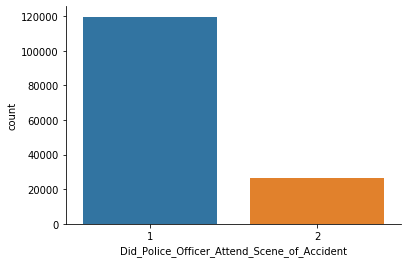

In [7]:
# Visualizing the countplot for the Target Variable if Police Officer will attend the scene
sns.countplot(road_safety["Did_Police_Officer_Attend_Scene_of_Accident"])
sns.despine()

In [13]:
road_safety["VDate"] = pd.to_datetime(road_safety["Date"])

In [14]:
road_safety["VDate"].dt.month.value_counts().sort_values()

2     10545
12    11324
4     11585
9     11951
3     12096
8     12359
5     12368
6     12383
1     12830
11    12869
7     12991
10    13021
Name: VDate, dtype: int64

Text(0.5, 1.0, 'Accident Count By Month')

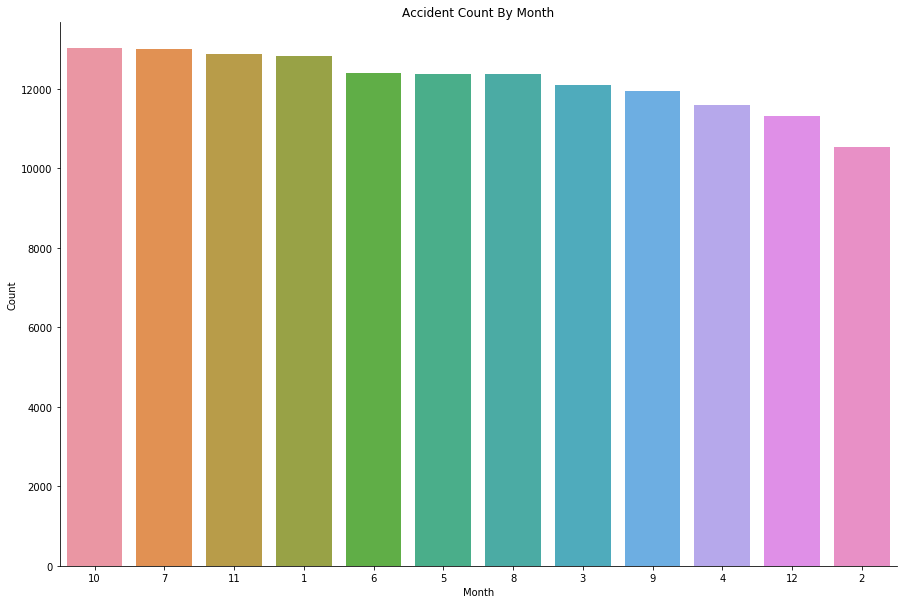

In [18]:
#road_safety["VDate"].dt.month.value_counts()
plt.figure(figsize=(15,10))
sns.countplot(road_safety["VDate"].dt.month, order=road_safety["VDate"].dt.month.value_counts().index)
sns.despine()
plt.xlabel("Month")
plt.ylabel("Count")
plt.title("Accident Count By Month")

## Week of Day Accident Count
### Day of the week
    1	Sunday
    2	Monday
    3	Tuesday
    4	Wednesday
    5	Thursday
    6	Friday
    7	Saturday

In [13]:
road_safety["Day_of_Week"].value_counts().index

Int64Index([6, 3, 4, 5, 2, 7, 1], dtype='int64')

In [14]:
np.mean(road_safety["Day_of_Week"].value_counts())

20903.14285714286

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  """
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  """
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Legend does not support 3 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  """


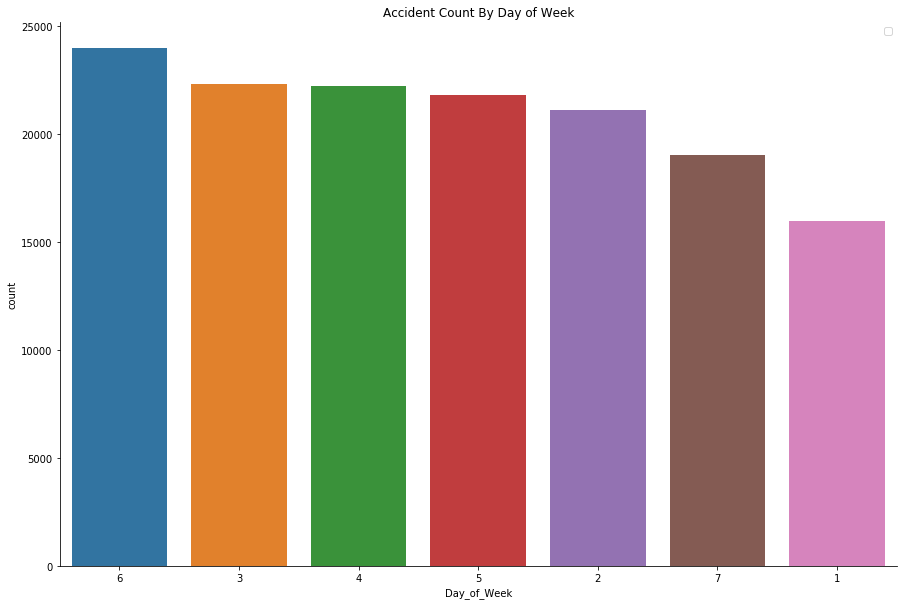

In [26]:
plt.figure(figsize=(15,10))
plt.xlabel("Day of Week")
plt.ylabel("Count")
plt.title("Accident Count By Day of Week")
plt.legend((1,2,3),('label1', 'label2', 'label3'))
plt.legend()
sns.despine()
sns.countplot(road_safety["Day_of_Week"], order=road_safety["Day_of_Week"].value_counts().index)

In [16]:
road_safety.groupby(["Day_of_Week","Did_Police_Officer_Attend_Scene_of_Accident"])["Accident_Index"].count()

Day_of_Week  Did_Police_Officer_Attend_Scene_of_Accident
1            1                                              13582
             2                                               2358
2            1                                              17128
             2                                               3965
3            1                                              17946
             2                                               4372
4            1                                              17810
             2                                               4400
5            1                                              17658
             2                                               4122
6            1                                              19519
             2                                               4441
7            1                                              15964
             2                                               3057
Name: Accident_Inde

### Analysis on Day of the Week

    - Friday seems to have the maximum number of incidents 
        - Possibly look at other datasets like Beer Sales etc, to see if this is related
        - Possibly for people on the road going back home
    - Sunday is the lowest. Would be interesting to see number of people on the road.
        - Possibly as it is a Church day
    - Between Friday and Monday, the difference is almost 50% more
    - Avg of 21K accindents per day of the week
    - Maximum Policy Attendance is 4441

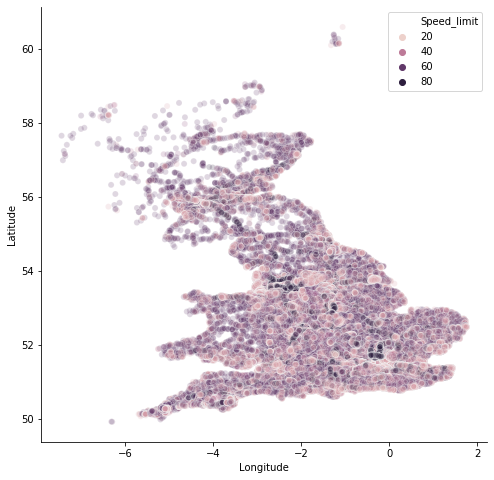

In [17]:
plt.figure(figsize=(8,8))
#road_safety.plot(kind="scatter", x="Longitude", y="Latitude", alpha=0.4)
sns.scatterplot( x="Longitude", y="Latitude",data=road_safety,hue="Speed_limit", alpha=0.2)
sns.despine()

In [18]:
road_safety.corr()

,Location_Easting_OSGR,Location_Northing_OSGR,Longitude,Latitude,Police_Force,Accident_Severity,Number_of_Vehicles,Number_of_Casualties,Day_of_Week,Local_Authority_(District),...,2nd_Road_Number,Pedestrian_Crossing-Human_Control,Pedestrian_Crossing-Physical_Facilities,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Special_Conditions_at_Site,Carriageway_Hazards,Urban_or_Rural_Area,Did_Police_Officer_Attend_Scene_of_Accident
Location_Easting_OSGR,1.000000,-0.432557,0.999384,-0.434713,-0.365694,0.053299,0.009245,-0.035971,-0.002208,-0.389549,...,-0.026646,-0.030061,0.068541,0.008765,-0.014439,-0.076629,-0.022693,0.007157,-0.111793,0.018866
Location_Northing_OSGR,-0.432557,1.000000,-0.442093,0.999972,0.175652,-0.039698,-0.027116,0.029116,0.009922,0.132811,...,0.045491,0.044756,-0.026101,-0.003615,0.017663,0.066313,0.018611,-0.002487,0.056726,-0.003271
Longitude,0.999384,-0.442093,1.000000,-0.444149,-0.378228,0.053200,0.010201,-0.034669,-0.002392,-0.398955,...,-0.024565,-0.030954,0.067375,0.008524,-0.014800,-0.077244,-0.022549,0.006861,-0.109947,0.019412
Latitude,-0.434713,0.999972,-0.444149,1.000000,0.173710,-0.039821,-0.026902,0.029246,0.009925,0.131211,...,0.046321,0.044706,-0.025962,-0.003623,0.017560,0.066261,0.018582,-0.002607,0.056248,-0.003168
Police_Force,-0.365694,0.175652,-0.378228,0.173710,1.000000,-0.062724,0.001604,0.013969,-0.000013,0.980748,...,-0.017590,0.028665,-0.082666,0.012996,0.027608,0.091896,0.025559,0.010485,0.250918,-0.004396
Accident_Severity,0.053299,-0.039698,0.053200,-0.039821,-0.062724,1.000000,0.074668,-0.058472,0.006482,-0.068532,...,0.021755,0.004877,0.021911,-0.054272,0.017993,0.001099,-0.003196,-0.000343,-0.094007,0.106202
Number_of_Vehicles,0.009245,-0.027116,0.010201,-0.026902,0.001604,0.074668,1.000000,0.229829,0.004694,0.005823,...,0.017809,-0.012357,-0.049030,-0.080012,-0.031748,-0.049998,-0.010835,-0.053413,0.051230,-0.044941
Number_of_Casualties,-0.035971,0.029116,-0.034669,0.029246,0.013969,-0.058472,0.229829,1.000000,0.000711,0.020365,...,0.000482,-0.001849,-0.031372,0.020438,-0.003670,0.018516,0.008124,-0.002630,0.114192,-0.101568
Day_of_Week,-0.002208,0.009922,-0.002392,0.009925,-0.000013,0.006482,0.004694,0.000711,1.000000,-0.001222,...,-0.000846,-0.002412,0.009054,0.006943,0.013423,0.008116,-0.005718,-0.003074,-0.017397,0.001502
Local_Authority_(District),-0.389549,0.132811,-0.398955,0.131211,0.980748,-0.068532,0.005823,0.020365,-0.001222,1.000000,...,-0.013798,0.025393,-0.095660,0.010804,0.029541,0.092844,0.027448,0.009283,0.266617,-0.002545


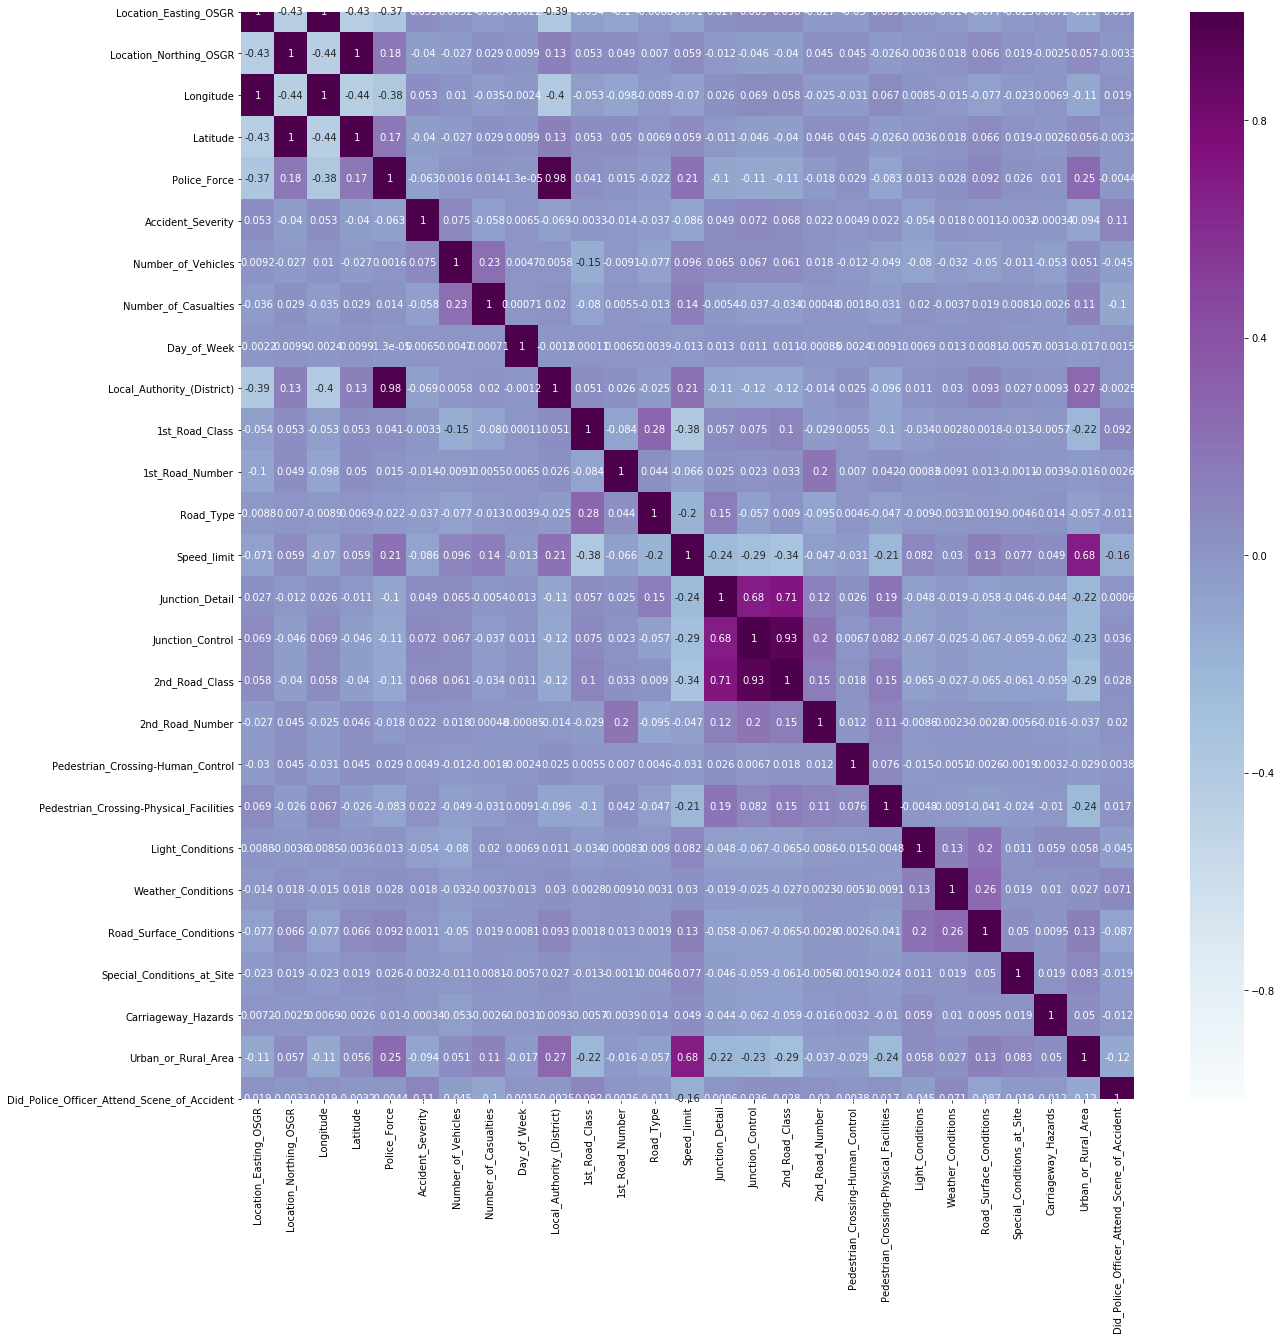

In [19]:
plt.figure(figsize=(20,20))

sns.heatmap(road_safety.corr(),cmap="BuPu", annot=True, vmin=-1, vmax=1)

### Road Type
    1	Roundabout
    2	One way street
    3	Dual carriageway
    6	Single carriageway
    7	Slip road
    9	Unknown
    12  One way street/Slip road

In [20]:
road_safety.groupby(["Road_Type"])["Accident_Index"].count().sort_values(ascending=False)

Road_Type
6    110187
3     20823
1     10329
2      2935
7      1542
9       506
Name: Accident_Index, dtype: int64

### Analysis
    - Single Carriage ways have the most accidents

### Weather Conditions

    1	Fine no high winds
    2	Raining no high winds
    3	Snowing no high winds
    4	Fine + high winds
    5	Raining + high winds
    6	Snowing + high winds
    7	Fog or mist
    8	Other
    9	Unknown

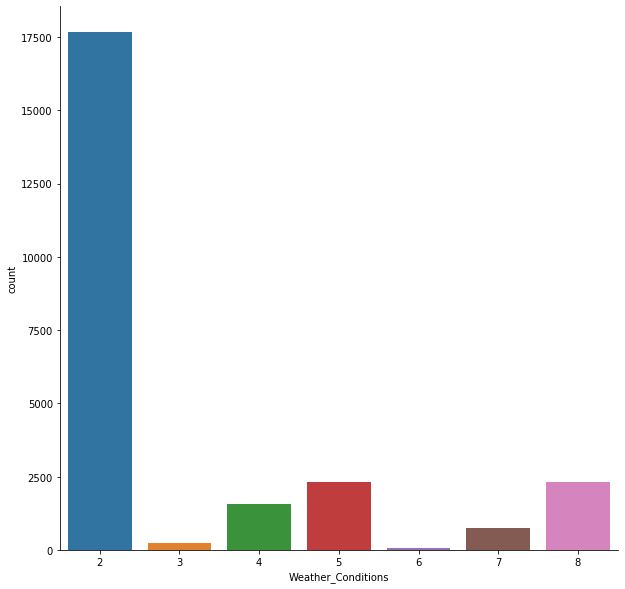

In [35]:
plt.figure(figsize=(10,10))
plt.xlabel("Weather Condition")
sns.countplot(road_safety[road_safety["Weather_Conditions"].isin([2,3,4,5,6,7,8])]["Weather_Conditions"])
sns.despine()

In [21]:
road_safety.groupby(["Weather_Conditions","Did_Police_Officer_Attend_Scene_of_Accident"])["Accident_Index"].count().sort_values(ascending=False)

Weather_Conditions  Did_Police_Officer_Attend_Scene_of_Accident
1                   1                                              97189
                    2                                              21690
2                   1                                              15145
                    2                                               2520
5                   1                                               2038
8                   1                                               1905
9                   2                                               1436
4                   1                                               1360
9                   1                                               1044
7                   1                                                667
8                   2                                                427
5                   2                                                295
4                   2                                       

## Analysis
-  Rain is the biggest cause of Road Accidents which is related to weather

### Light Conditions
    1	Daylight
    4	Darkness - lights lit
    5	Darkness - lights unlit
    6	Darkness - no lighting
    7	Darkness - lighting unknown

In [22]:

road_safety.groupby(["Light_Conditions"])["Accident_Index"].count().sort_values(ascending=False)

Light_Conditions
1    108071
4     28449
6      7199
7      1731
5       872
Name: Accident_Index, dtype: int64

### Lighting Condition

More Accidents happened in the Lighting condition than Darkness. But total traffic in lighting is perhaps higher. It is not a very good indicator. As a ratio would be a better indicator.

In [23]:
road_safety.groupby(["1st_Road_Class","Did_Police_Officer_Attend_Scene_of_Accident"])["Accident_Index"].count().sort_values(ascending=False)

1st_Road_Class  Did_Police_Officer_Attend_Scene_of_Accident
3               1                                              56804
6               1                                              31684
4               1                                              15319
3               2                                              11024
5               1                                              10589
6               2                                               9638
1               1                                               4857
4               2                                               3254
5               2                                               2380
1               2                                                389
2               1                                                354
                2                                                 30
Name: Accident_Index, dtype: int64

In [24]:
road_safety.groupby(["Number_of_Vehicles","Did_Police_Officer_Attend_Scene_of_Accident"])["Accident_Index"].count()

Number_of_Vehicles  Did_Police_Officer_Attend_Scene_of_Accident
1                   1                                              35882
                    2                                               7289
2                   1                                              70166
                    2                                              18426
3                   1                                              10425
                    2                                                904
4                   1                                               2346
                    2                                                 89
5                   1                                                528
                    2                                                  5
6                   1                                                156
                    2                                                  1
7                   1                                       

In [25]:
road_safety.groupby(["Police_Force"])["Accident_Index"].count().sort_values(ascending=False)

Police_Force
1     25682
20     5603
43     5429
46     5279
13     5043
44     4527
47     4297
42     4117
6      4004
50     3967
45     3962
4      3879
97     3650
52     3263
10     3198
14     3168
31     2880
5      2831
21     2799
16     2689
7      2673
41     2634
33     2479
30     2400
62     2328
22     2327
32     2194
95     2160
35     2049
12     2036
36     1882
55     1826
37     1761
23     1653
40     1577
54     1574
60     1415
3      1397
34     1301
63     1249
11     1242
17      889
61      884
53      798
92      778
91      516
93      510
96      454
94      411
48      348
98      310
Name: Accident_Index, dtype: int64

In [42]:
df_acc = pd.DataFrame(road_safety["Accident_Severity"].value_counts())
df_acc["percentage"] = round(df_acc["Accident_Severity"]*100/df_acc["Accident_Severity"].sum(),2)
df_acc["severity"] = df_acc.index

Text(0, 0.5, 'Percentage')

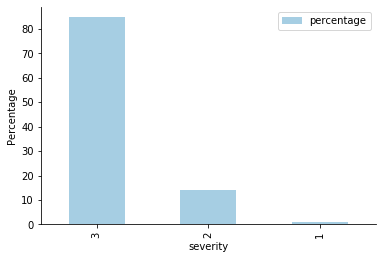

In [47]:

df_acc.plot(kind='bar',x="severity",y='percentage',colormap='Paired')
sns.despine()
plt.ylabel("Percentage")

## Accident Severity
- Very few accidents are fatal
- Most Accidents are Slight

### Certain locations have higher accidents than others



In [27]:
road_safety.groupby(["LSOA_of_Accident_Location"]).count()["Accident_Index"].sort_values(ascending=False)

LSOA_of_Accident_Location
E01032739    242
E01004736    142
E01033595     91
E01004689     82
E01032740     78
            ... 
E01028078      1
E01028079      1
E01028082      1
E01028086      1
E01018013      1
Name: Accident_Index, Length: 29122, dtype: int64

### Urban Vs Rural

- How does the data compare Urban vs Rural

In [28]:
# 1 is Urban, 2 is Rural
# There is better attendance in Rural as a percentage compared to Urban
road_safety.groupby(["Urban_or_Rural_Area","Did_Police_Officer_Attend_Scene_of_Accident"])["Accident_Index"].count()

Urban_or_Rural_Area  Did_Police_Officer_Attend_Scene_of_Accident
1                    1                                              75471
                     2                                              20816
2                    1                                              44136
                     2                                               5899
Name: Accident_Index, dtype: int64

In [51]:
road_safety.groupby(["Speed_limit","Did_Police_Officer_Attend_Scene_of_Accident","Urban_or_Rural_Area"])["Accident_Index"].count()

Speed_limit  Did_Police_Officer_Attend_Scene_of_Accident  Urban_or_Rural_Area
20           1                                            1                       2284
                                                          2                        154
             2                                            1                        920
                                                          2                         60
30           1                                            1                      64576
                                                          2                       9311
             2                                            1                      18454
                                                          2                       2656
40           1                                            1                       5351
                                                          2                       4939
             2                                      

In [49]:
acc_police_att = road_safety.groupby(["Accident_Severity","Did_Police_Officer_Attend_Scene_of_Accident"])["Accident_Index"].count()

Text(0.5, 1.0, 'Accident Counts By Police Attendance')

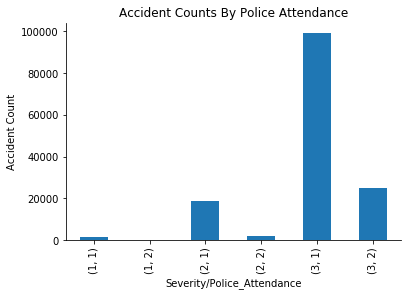

In [52]:
acc_police_att.plot.bar(x="Accident_Severity", y="Did_Police_Officer_Attend_Scene_of_Accident")
sns.despine()
plt.ylabel("Accident Count")
plt.xlabel("Severity/Police_Attendance")
plt.title("Accident Counts By Police Attendance")

In [51]:
count = 0
rolling_sum= 0
for acc in acc_police_att:   
    rolling_sum += acc
    #print(rolling_sum)
    count+=1
    print (acc)
    if (count%2) == 0:
        print ((acc*1.0/rolling_sum)* 100)
        rolling_sum=0

1638
20
1.2062726176115801
18735
1941
9.387695879280326
99234
24754
19.964835306642577


In [62]:
road_safety.groupby(["Police_Force","Did_Police_Officer_Attend_Scene_of_Accident"])["Accident_Index"].count()

Police_Force  Did_Police_Officer_Attend_Scene_of_Accident
1             1                                              21200
              2                                               4482
3             1                                               1066
              2                                                331
4             1                                               3879
5             1                                               2307
              2                                                524
6             1                                               3507
              2                                                497
7             1                                               2122
              2                                                551
10            1                                               2377
              2                                                821
11            1                                                909
    

### Distribution of Accidents by Time

In [63]:
# Too big to plat
#plt.figure(figsize=(500,200))
#sns.countplot(road_safety["Time"])

### Accident Severity Code
    1	Fatal
    2	Serious
    3	Slight

# Model Training

### Prepare Categorical data

- Lets prepare the categorical dataset
- Convert them into index
- Some columns are colinear so it does not make sense to have them twice in the design matrix
    - ~'Accident_Index'~ 
    - 'Location_Easting_OSGR',
    - 'Location_Northing_OSGR',
    -  ~'Longitude',  [Colinear to Locaton_EastingOSGR]~
    - ~'Latitude', [Colinear Locaton_..]~
    - 'Police_Force', 
    - 'Accident_Severity',
    - 'Number_of_Vehicles',
    - 'Number_of_Casualties', 
    - ~'Date',~
    - 'Day_of_Week',
    - 'Time', 
    - 'Local_Authority_(District)', 
    - 'Local_Authority_(Highway)',
    - '1st_Road_Class',
    - '1st_Road_Number',
    - 'Road_Type', 
    - 'Speed_limit',
    - 'Junction_Detail',
    - ~'Junction_Control',  [Colinea]~
    - ~'2nd_Road_Class', [Colinear]~
    - '2nd_Road_Number', 
    - 'Pedestrian_Crossing-Human_Control',
    - 'Pedestrian_Crossing-Physical_Facilities', 
    - 'Light_Conditions',
    - 'Weather_Conditions', 
    - 'Road_Surface_Conditions',
    - 'Special_Conditions_at_Site', 
    - 'Carriageway_Hazards',
    - 'Urban_or_Rural_Area', 
    - 'Did_Police_Officer_Attend_Scene_of_Accident',
    - ~LSOA_of_Accident_Location~



In [72]:
cols = ['Location_Easting_OSGR','Location_Northing_OSGR','Police_Force',  'Accident_Severity','Number_of_Vehicles','Number_of_Casualties', 'Day_of_Week','Time', 'Local_Authority_(District)', 
    'Local_Authority_(Highway)','1st_Road_Class','1st_Road_Number','Road_Type', 'Speed_limit','Junction_Detail','2nd_Road_Number', 
    'Pedestrian_Crossing-Human_Control','Pedestrian_Crossing-Physical_Facilities', 'Light_Conditions','Weather_Conditions', 
    'Road_Surface_Conditions','Special_Conditions_at_Site', 'Carriageway_Hazards','Urban_or_Rural_Area','Did_Police_Officer_Attend_Scene_of_Accident']

In [73]:
road_safety_sel = road_safety[cols]

In [82]:
road_safety_sel.to_pickle("road_safety_sel2.pkl")

In [79]:
# Sacle the Location Easting OSGR

scaler = MinMaxScaler()
LEO = pd.DataFrame(road_safety_sel["Location_Easting_OSGR"])
LEO2= pd.DataFrame(scaler.fit_transform(LEO), columns=["Location_Easting_scaled"])
road_safety_sel =pd.concat([road_safety_sel,LEO2],axis=1)
LNO = pd.DataFrame(road_safety_sel["Location_Northing_OSGR"])
LNO2= pd.DataFrame(scaler.fit_transform(LNO), columns=["Location_Northing_scaled"])
road_safety_sel =pd.concat([road_safety_sel,LNO2],axis=1)

In [76]:
def change_clocktime_mins(strtime):
    return int(strtime.split(":")[0]) *60 +int(strtime.split(":")[1])
change_clocktime_mins("13:21")


def scale_cols(road_safety_sel,cols, scale_cols):
    dfcol = pd.DataFrame(road_safety_sel[cols])
    dfcol2= pd.DataFrame(scaler.fit_transform(dfcol), columns=[scale_cols])
    road_safety_sel =pd.concat([road_safety_sel,dfcol2],axis=1)
    return road_safety_sel

In [77]:
road_safety_sel["time_mins"] = road_safety_sel.Time.apply(change_clocktime_mins)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [80]:
road_safety_sel = scale_cols(road_safety_sel,"time_mins", "time_mins_scaled")

In [81]:
road_safety_sel["time_mins_scaled"].head(3)

0    0.556328
1    0.958971
2    0.444367
Name: time_mins_scaled, dtype: float64

In [31]:
road_safety_sel.drop(columns=["Time","Location_Easting_OSGR", "Location_Northing_OSGR"], axis=1, inplace=True)

In [32]:
def fn_cols_unique(col):
    print (col, len(road_safety_sel[col].unique()))


In [33]:
cols = ['Police_Force',  'Accident_Severity','Number_of_Vehicles','Number_of_Casualties','Local_Authority_(Highway)', 'Day_of_Week', 'Local_Authority_(District)', 
    '1st_Road_Class','1st_Road_Number','Road_Type', 'Speed_limit','Junction_Detail','2nd_Road_Number', 
    'Pedestrian_Crossing-Human_Control','Pedestrian_Crossing-Physical_Facilities', 'Light_Conditions','Weather_Conditions', 
    'Road_Surface_Conditions','Special_Conditions_at_Site', 'Carriageway_Hazards','Urban_or_Rural_Area']

for colname in cols:
    fn_cols_unique(colname)

Police_Force 51
Accident_Severity 3
Number_of_Vehicles 14
Number_of_Casualties 26
Local_Authority_(Highway) 207
Day_of_Week 7
Local_Authority_(District) 380
1st_Road_Class 6
1st_Road_Number 4384
Road_Type 6
Speed_limit 6
Junction_Detail 9
2nd_Road_Number 3869
Pedestrian_Crossing-Human_Control 3
Pedestrian_Crossing-Physical_Facilities 6
Light_Conditions 5
Weather_Conditions 9
Road_Surface_Conditions 6
Special_Conditions_at_Site 9
Carriageway_Hazards 7
Urban_or_Rural_Area 2


In [34]:
# Dropping first and second road number

road_safety_sel.drop(columns=["1st_Road_Number","2nd_Road_Number"], axis=1, inplace=True)

In [35]:
road_safety_sel.columns

Index(['Police_Force', 'Accident_Severity', 'Number_of_Vehicles',
       'Number_of_Casualties', 'Day_of_Week', 'Local_Authority_(District)',
       'Local_Authority_(Highway)', '1st_Road_Class', 'Road_Type',
       'Speed_limit', 'Junction_Detail', 'Pedestrian_Crossing-Human_Control',
       'Pedestrian_Crossing-Physical_Facilities', 'Light_Conditions',
       'Weather_Conditions', 'Road_Surface_Conditions',
       'Special_Conditions_at_Site', 'Carriageway_Hazards',
       'Urban_or_Rural_Area', 'Did_Police_Officer_Attend_Scene_of_Accident',
       'Location_Easting_scaled', 'Location_Northing_scaled', 'time_mins',
       'time_mins_scaled'],
      dtype='object')

In [36]:
road_safety_sel.head()

,Police_Force,Accident_Severity,Number_of_Vehicles,Number_of_Casualties,Day_of_Week,Local_Authority_(District),Local_Authority_(Highway),1st_Road_Class,Road_Type,Speed_limit,...,Weather_Conditions,Road_Surface_Conditions,Special_Conditions_at_Site,Carriageway_Hazards,Urban_or_Rural_Area,Did_Police_Officer_Attend_Scene_of_Accident,Location_Easting_scaled,Location_Northing_scaled,time_mins,time_mins_scaled
0,1,3,2,1,5,12,E09000020,3,6,30,...,2,2,0,0,1,2,0.776320,0.142913,801,0.556328
1,1,3,2,1,2,12,E09000020,3,6,30,...,1,1,0,0,1,2,0.778340,0.142294,1380,0.958971
2,1,3,2,1,3,12,E09000020,3,6,30,...,1,1,0,0,1,1,0.780222,0.142413,640,0.444367
3,1,3,1,1,4,12,E09000020,5,6,30,...,1,1,0,0,1,2,0.777997,0.142963,1065,0.739917
4,1,3,2,1,5,12,E09000020,3,6,30,...,1,1,0,0,1,1,0.780496,0.142921,530,0.367872


In [37]:
road_safety_sel.drop(columns=["time_mins"], axis=1, inplace=True)

In [38]:
road_safety_sel.head()

,Police_Force,Accident_Severity,Number_of_Vehicles,Number_of_Casualties,Day_of_Week,Local_Authority_(District),Local_Authority_(Highway),1st_Road_Class,Road_Type,Speed_limit,...,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Special_Conditions_at_Site,Carriageway_Hazards,Urban_or_Rural_Area,Did_Police_Officer_Attend_Scene_of_Accident,Location_Easting_scaled,Location_Northing_scaled,time_mins_scaled
0,1,3,2,1,5,12,E09000020,3,6,30,...,1,2,2,0,0,1,2,0.776320,0.142913,0.556328
1,1,3,2,1,2,12,E09000020,3,6,30,...,7,1,1,0,0,1,2,0.778340,0.142294,0.958971
2,1,3,2,1,3,12,E09000020,3,6,30,...,1,1,1,0,0,1,1,0.780222,0.142413,0.444367
3,1,3,1,1,4,12,E09000020,5,6,30,...,4,1,1,0,0,1,2,0.777997,0.142963,0.739917
4,1,3,2,1,5,12,E09000020,3,6,30,...,1,1,1,0,0,1,1,0.780496,0.142921,0.367872


In [39]:
def convert_to_dummies(wdf, cols):
    for colname in cols:
        wdf = pd.concat([wdf,pd.get_dummies(wdf[colname], prefix=colname)],axis=1)
        wdf.drop(columns=[colname], axis=1, inplace=True)
    return wdf


In [40]:
cols_to_dummies = ['Police_Force',  'Accident_Severity','Number_of_Vehicles','Number_of_Casualties', 'Day_of_Week','Local_Authority_(Highway)', 'Local_Authority_(District)', 
    '1st_Road_Class','Road_Type', 'Speed_limit','Junction_Detail', 
    'Pedestrian_Crossing-Human_Control','Pedestrian_Crossing-Physical_Facilities', 'Light_Conditions','Weather_Conditions', 
    'Road_Surface_Conditions','Special_Conditions_at_Site', 'Carriageway_Hazards','Urban_or_Rural_Area']
road_safety_dumm = convert_to_dummies(road_safety_sel, cols_to_dummies)

In [41]:
road_safety_dumm.head(3)

,Did_Police_Officer_Attend_Scene_of_Accident,Location_Easting_scaled,Location_Northing_scaled,time_mins_scaled,Police_Force_1,Police_Force_3,Police_Force_4,Police_Force_5,Police_Force_6,Police_Force_7,...,Special_Conditions_at_Site_7,Carriageway_Hazards_-1,Carriageway_Hazards_0,Carriageway_Hazards_1,Carriageway_Hazards_2,Carriageway_Hazards_3,Carriageway_Hazards_6,Carriageway_Hazards_7,Urban_or_Rural_Area_1,Urban_or_Rural_Area_2
0,2,0.776320,0.142913,0.556328,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
1,2,0.778340,0.142294,0.958971,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
2,1,0.780222,0.142413,0.444367,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0


In [42]:
len(road_safety_dumm.columns)

766

In [43]:
# Crete The Target Variable
target_df = pd.DataFrame(road_safety_dumm.Did_Police_Officer_Attend_Scene_of_Accident)

In [44]:
target_df.Did_Police_Officer_Attend_Scene_of_Accident.value_counts()

1    119607
2     26715
Name: Did_Police_Officer_Attend_Scene_of_Accident, dtype: int64

In [45]:
features_df = road_safety_dumm.drop(columns=["Did_Police_Officer_Attend_Scene_of_Accident"], axis=1)

In [46]:
# recommend from 20-30 for test and impabalanced classes
# Do Split of Train Test of 80, 20
X_train, X_test, y_train, y_test = train_test_split(features_df, target_df, test_size=0.2, random_state=42,
                                                    stratify=target_df)

In [47]:
print ("X Train size:", len(X_train))
print ("Y Train size:", len(y_train))
print ("X Test  Size:", len(X_test))
print ("Y Test  Size:", len(y_test))

X Train size: 117057
Y Train size: 117057
X Test  Size: 29265
Y Test  Size: 29265


In [58]:
X_train.to_pickle("dataframe/train/x_train.pkl")
X_test.to_pickle("dataframe/train/x_test.pkl")
y_train.to_pickle("dataframe/test/y_train.pkl")
y_test.to_pickle("dataframe/test/y_test.pkl")

In [21]:
X_train = pd.read_pickle("dataframe/train/x_train.pkl")
X_test = pd.read_pickle("dataframe/train/x_test.pkl")
y_train = pd.read_pickle("dataframe/test/y_train.pkl")
y_test = pd.read_pickle("dataframe/test/y_test.pkl")

## Linear SVC

In [22]:
# Helper function for printing confusion matrices (see: https://gist.github.com/shaypal5/94c53d765083101efc0240d776a23823)

# prints confusion matrix as a heatmap which is nicer to visaulize

def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=18):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names, )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig

In [23]:
X_train.head()

,Location_Easting_scaled,Location_Northing_scaled,time_mins_scaled,Police_Force_1,Police_Force_3,Police_Force_4,Police_Force_5,Police_Force_6,Police_Force_7,Police_Force_10,...,Special_Conditions_at_Site_7,Carriageway_Hazards_-1,Carriageway_Hazards_0,Carriageway_Hazards_1,Carriageway_Hazards_2,Carriageway_Hazards_3,Carriageway_Hazards_6,Carriageway_Hazards_7,Urban_or_Rural_Area_1,Urban_or_Rural_Area_2
123175,0.378080,0.065675,0.677330,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
144953,0.375243,0.554039,0.628651,0,0,0,0,0,0,0,...,1,0,1,0,0,0,0,0,0,1
80461,0.665421,0.250254,0.889430,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
119856,0.733708,0.077390,0.016690,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
125773,0.499961,0.143790,0.687761,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0


In [24]:
def quick_test(model, X_train, y_train, X_test, y_test):
    #xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3)
    model.fit(X_train, y_train)
    return model.score(X_test, y_test)

def quick_test_afew_times(model, X, y,x1,y1, n=10):
    return np.mean([quick_test(model, X, y,x1,y1) for j in range(n)])

In [90]:
linearsvc = LinearSVC()
# Do the test 10 times with a LinearSVC and get the average score
quick_test_afew_times(linearsvc, X_train, y_train, X_test,y_test)

/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

0.8230650948231675

In [94]:
for j in range(2,10): 
 decisiontree = DecisionTreeClassifier(max_depth=j)
 print (quick_test_afew_times(decisiontree,X_train, y_train, X_test,y_test))

0.820912352639672
0.8214249103024092
0.8225183666495814
0.8229625832906201
0.8229557491884503
0.8225525371604305
0.8217905347684947
0.8216128481120792


In [ ]:
# The Best Score for Decision Tree and LinearSVC is 0.823

In [ ]:
s2 = SVC(gamma="scale")
quick_test_afew_times(s2, X_train, y_train, X_test,y_test)

/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [80]:
randomforest = RandomForestClassifier(n_estimators=1000)
#clf = randomforest.fit(X_train, y_train)

In [ ]:
print (quick_test_afew_times(randomforest,X_train, y_train, X_test,y_test))

In [7]:
! mkdir models

In [9]:
# save the model to disk
filename = 'models/RandomForestClassifierModel.h5'
pickle.dump(randomforest, open(filename, 'wb'))

## Using a Keras Deep Learning Model

In [14]:
y_test

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [28]:

# encode the output label
from keras.utils import np_utils
y_orig_test = y_test
encoder = LabelEncoder()
encoder.fit(y_test)
y_test = encoder.transform(y_test)
#y_test = np_utils.to_categorical(y_test)

In [24]:
y_orig_train = y_train
encoder = LabelEncoder()
encoder.fit(y_train)
y_train = encoder.transform(y_train)
#y_train = np_utils.to_categorical(y_train)

/usr/local/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [25]:
import keras
DROP = .2

police_model = keras.Sequential([
#     keras.layers.Dropout(.1),
    keras.layers.Dense(units= 100,activation="relu", input_shape=X_train.shape[1:]),
    keras.layers.Dropout(DROP),
    keras.layers.Dense(units= 50,activation="relu"),
    keras.layers.Dropout(DROP),
    keras.layers.Dense(units= 25,activation="relu"),
    keras.layers.Dropout(DROP),
    keras.layers.Dense(units=1, activation='sigmoid'),
])

police_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'] )
police_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 100)               76600     
_________________________________________________________________
dropout_13 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 50)                5050      
_________________________________________________________________
dropout_14 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_19 (Dense)             (None, 25)                1275      
_________________________________________________________________
dropout_15 (Dropout)         (None, 25)                0         
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 26        
Total para

In [26]:
scores = police_model.fit(
    x=X_train, y=y_train, epochs=100, validation_split=.25, verbose=1)

Train on 87792 samples, validate on 29265 samples
Epoch 1/100
87792/87792 [==============================] - 22s 251us/step - loss: 0.4339 - acc: 0.8182 - val_loss: 0.4179 - val_acc: 0.8215
Epoch 2/100
87792/87792 [==============================] - 20s 226us/step - loss: 0.4186 - acc: 0.8209 - val_loss: 0.4181 - val_acc: 0.8224
Epoch 3/100
87792/87792 [==============================] - 19s 219us/step - loss: 0.4143 - acc: 0.8227 - val_loss: 0.4174 - val_acc: 0.8228
Epoch 4/100
87792/87792 [==============================] - 20s 233us/step - loss: 0.4098 - acc: 0.8230 - val_loss: 0.4192 - val_acc: 0.8227
Epoch 5/100
87792/87792 [==============================] - 21s 239us/step - loss: 0.4051 - acc: 0.8241 - val_loss: 0.4179 - val_acc: 0.8221
Epoch 6/100
87792/87792 [==============================] - 20s 230us/step - loss: 0.4009 - acc: 0.8248 - val_loss: 0.4209 - val_acc: 0.8223
Epoch 7/100
87792/87792 [==============================] - 21s 237us/step - loss: 0.3957 - acc: 0.8263 - val_l

Epoch 59/100
87792/87792 [==============================] - 21s 235us/step - loss: 0.2923 - acc: 0.8659 - val_loss: 0.6256 - val_acc: 0.7934
Epoch 60/100
87792/87792 [==============================] - 21s 234us/step - loss: 0.2900 - acc: 0.8664 - val_loss: 0.6498 - val_acc: 0.7945
Epoch 61/100
87792/87792 [==============================] - 21s 234us/step - loss: 0.2906 - acc: 0.8667 - val_loss: 0.6192 - val_acc: 0.7969
Epoch 62/100
87792/87792 [==============================] - 21s 237us/step - loss: 0.2901 - acc: 0.8678 - val_loss: 0.6120 - val_acc: 0.7964
Epoch 63/100
87792/87792 [==============================] - 21s 244us/step - loss: 0.2893 - acc: 0.8686 - val_loss: 0.6840 - val_acc: 0.7947
Epoch 64/100
87792/87792 [==============================] - 21s 243us/step - loss: 0.2895 - acc: 0.8684 - val_loss: 0.6625 - val_acc: 0.8008
Epoch 65/100
87792/87792 [==============================] - 21s 237us/step - loss: 0.2880 - acc: 0.8683 - val_loss: 0.6578 - val_acc: 0.7983
Epoch 66/100


In [27]:
police_model.save("models/KerasModelrelu.h5")

In [29]:
police_model.evaluate(X_test,y_test)

29265/29265 [==============================] - 2s 55us/step


[0.718246891261084, 0.7914573722938258]

In [30]:
prediction_classes  = police_model.predict_classes(X_test)

In [32]:
y_predict_class = encoder.inverse_transform(prediction_classes)

/usr/local/lib/python3.7/site-packages/sklearn/preprocessing/label.py:273: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [33]:
y_predict_class

array([1, 1, 1, ..., 1, 1, 1])

In [35]:
y_orig_test["prediction"] = y_predict_class

In [39]:
y_orig_test

,Did_Police_Officer_Attend_Scene_of_Accident,prediction
13320,1,1
73996,1,1
109917,1,1
135389,1,1
87263,1,1
20270,1,1
118509,1,1
2724,2,1
111666,1,1
25592,1,1


In [66]:
conf_mat = confusion_matrix(y_true=y_test, y_pred=y_predict_class)
#cm = print_confusion_matrix(conf_mat, ['show', 'noshow'])

In [67]:
conf_mat = conf_mat[:2,1:]


In [68]:
conf_mat

array([[22033,  1889],
       [ 4214,  1129]])

Text(33.0, 0.5, 'actual')

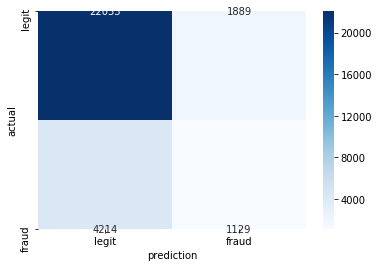

In [64]:
sns.heatmap(conf_mat, cmap=plt.cm.Blues, annot=True,  fmt='d',
           xticklabels=['legit', 'fraud'],
           yticklabels=['legit', 'fraud']);
plt.xlabel('prediction')
plt.ylabel('actual')

### Gradient Boosted Trees

In [31]:
xgb_model = XGBClassifier(objective="binary:logistic", colsample_bytree=0.7,
 learning_rate= 0.05,
 max_depth= 10,
 min_child_weight= 11,
 n_estimators=1000,
 seed = 1337,
 subsample=0.8,
 verbose=2)

In [76]:
xgb_model.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, gamma=0,
              learning_rate=0.05, max_delta_step=0, max_depth=10,
              min_child_weight=11, missing=None, n_estimators=1000, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=1337,
              silent=None, subsample=0.8, verbose=2, verbosity=1)

In [77]:
xgb_model.score(X_test,y_test)

0.8270630445925167

XGBoost has the best test score of <b>0.8270630445925167</b>

In [1]:
# We have to do some Oversampling as the dataset is imbalanced

In [26]:
from imblearn.over_sampling import SMOTE, ADASYN

Using TensorFlow backend.
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

In [ ]:
sm = SMOTE()
adsyn = ADASYN()
X_train_oversampled, y_train_oversampled = sm.fit_sample(X_train, y_train)
X_train_oversampled_adsyn, y_train_oversampled_adsyn = adsyn.fit_sample(X_train, y_train)

/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [28]:
X_train_oversampled

array([[0.37807988, 0.0656751 , 0.67732962, ..., 0.        , 0.        ,
        1.        ],
       [0.37524257, 0.55403904, 0.6286509 , ..., 0.        , 0.        ,
        1.        ],
       [0.66542086, 0.25025369, 0.88942976, ..., 0.        , 1.        ,
        0.        ],
       ...,
       [0.61307532, 0.44851467, 0.45728256, ..., 0.        , 0.        ,
        1.        ],
       [0.66388102, 0.28312518, 0.44647076, ..., 0.        , 1.        ,
        0.        ],
       [0.79108913, 0.14720874, 0.68908928, ..., 0.        , 1.        ,
        0.        ]])

In [32]:
xgb_model.fit(X_train_oversampled,y_train_oversampled)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, gamma=0,
              learning_rate=0.05, max_delta_step=0, max_depth=10,
              min_child_weight=11, missing=None, n_estimators=1000, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=1337,
              silent=None, subsample=0.8, verbose=2, verbosity=1)

In [36]:
#xgb_model.save("models/XGBModelSmote.h5")

pickle.dump(xgb_model, open("models/XGBModelSmote.h5", "wb"))

In [61]:
xgb_model.score(X_test.to_numpy(), y_test)

0.8218349564325986

In [48]:
std = StandardScaler()
X_test_scaled = std.fit_transform(X_test)

In [49]:
X_test_scaled

array([[ 0.95247078, -0.73285073,  1.74671181, ..., -0.06908233,
         0.71538666, -0.71538666],
       [ 0.11002235,  0.4427572 ,  1.70362723, ..., -0.06908233,
        -1.39784546,  1.39784546],
       [ 0.68363243, -0.76494019,  1.97539152, ..., -0.06908233,
        -1.39784546,  1.39784546],
       ...,
       [ 0.73246819, -0.85020359,  0.24206561, ..., -0.06908233,
        -1.39784546,  1.39784546],
       [ 0.82197591, -0.71434001, -1.12338425, ..., -0.06908233,
         0.71538666, -0.71538666],
       [ 0.99736648, -0.99684396,  1.04410169, ..., -0.06908233,
        -1.39784546,  1.39784546]])

In [63]:
y_pred=xgb_model.predict(X_test.to_numpy())

In [56]:
np.shape(X_train_oversampled)

(191370, 765)

In [64]:
conf_mat_xgb = confusion_matrix(y_true=y_test, y_pred=y_pred)
#cm = print_confusion_matrix(conf_mat, ['show', 'noshow'])

In [65]:
conf_mat_xgb

array([[23090,   832],
       [ 4382,   961]])

In [86]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           1       0.84      0.97      0.90     23922
           2       0.54      0.18      0.27      5343

    accuracy                           0.82     29265
   macro avg       0.69      0.57      0.58     29265
weighted avg       0.78      0.82      0.78     29265



             precision    recall  f1-score   support

           1       0.84      0.97      0.90     23922
           2       0.54      0.18      0.27      5343

    accuracy                           0.82     29265 \n
    macro avg       0.69      0.57      0.58     29265 \n
    weighted avg       0.78      0.82      0.78     29265 \n


In [90]:
roc_auc_score(y_test,y_pred)

0.5725409001677312

In [93]:
importances =xgb_model.feature_importances_

In [102]:

indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, cols2[indices[f]-1], importances[indices[f]]))


Feature ranking:
1. feature Number_of_Vehicles_21 (0.059841)
2. feature Accident_Severity_2 (0.028036)
3. feature Police_Force_3 (0.023387)
4. feature Speed_limit_20 (0.023228)
5. feature Day_of_Week_6 (0.017598)
6. feature Number_of_Vehicles_2 (0.017149)
7. feature Number_of_Casualties_93 (0.014910)
8. feature Number_of_Vehicles_1 (0.014212)
9. feature Road_Surface_Conditions_-1 (0.014046)
10. feature Day_of_Week_3 (0.012963)
11. feature Day_of_Week_2 (0.012467)
12. feature Day_of_Week_1 (0.011997)
13. feature Police_Force_61 (0.011911)
14. feature Day_of_Week_5 (0.011706)
15. feature Day_of_Week_4 (0.010642)
16. feature Accident_Severity_1 (0.009118)
17. feature Weather_Conditions_8 (0.008751)
18. feature Junction_Detail_5 (0.008422)
19. feature Junction_Detail_0 (0.008388)
20. feature Light_Conditions_1 (0.007956)
21. feature 1st_Road_Class_5 (0.007948)
22. feature Carriageway_Hazards_7 (0.007485)
23. feature Local_Authority_(Highway)_E10000016 (0.007288)
24. feature Pedestrian_Cros

318. feature Local_Authority_(District)_395 (0.000708)
319. feature Local_Authority_(Highway)_E06000047 (0.000704)
320. feature Local_Authority_(District)_206 (0.000700)
321. feature Local_Authority_(Highway)_E06000053 (0.000698)
322. feature Local_Authority_(District)_307 (0.000696)
323. feature Local_Authority_(District)_321 (0.000695)
324. feature Local_Authority_(Highway)_E06000038 (0.000693)
325. feature Local_Authority_(District)_606 (0.000692)
326. feature Local_Authority_(District)_139 (0.000690)
327. feature Local_Authority_(District)_450 (0.000690)
328. feature Local_Authority_(Highway)_E09000028 (0.000690)
329. feature Local_Authority_(District)_584 (0.000689)
330. feature Local_Authority_(District)_541 (0.000688)
331. feature Local_Authority_(Highway)_E08000016 (0.000687)
332. feature Local_Authority_(District)_241 (0.000683)
333. feature Local_Authority_(District)_931 (0.000683)
334. feature Local_Authority_(Highway)_S12000042 (0.000682)
335. feature Local_Authority_(Distr

610. feature Local_Authority_(Highway)_W06000014 (0.000392)
611. feature Local_Authority_(District)_149 (0.000392)
612. feature Local_Authority_(District)_551 (0.000391)
613. feature Local_Authority_(District)_92 (0.000390)
614. feature Local_Authority_(District)_413 (0.000390)
615. feature Local_Authority_(Highway)_S12000028 (0.000388)
616. feature Local_Authority_(District)_915 (0.000387)
617. feature Local_Authority_(District)_407 (0.000383)
618. feature Local_Authority_(District)_361 (0.000382)
619. feature Local_Authority_(District)_645 (0.000381)
620. feature Local_Authority_(Highway)_E06000014 (0.000379)
621. feature Special_Conditions_at_Site_0 (0.000378)
622. feature Local_Authority_(Highway)_W06000008 (0.000375)
623. feature Local_Authority_(District)_327 (0.000373)
624. feature Local_Authority_(District)_324 (0.000372)
625. feature Local_Authority_(District)_910 (0.000371)
626. feature Local_Authority_(District)_57 (0.000371)
627. feature Local_Authority_(Highway)_E06000044 

In [100]:
cols2 = X_train.columns